In [85]:
import transform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import Dropout

import warnings
warnings.filterwarnings("ignore")

In [86]:
df=pd.read_csv("Nifty50_Aug17_May20.csv")
df.Date = pd.to_datetime(df.Date)
df = df.set_index("Date")
df.head()

,Open,High,Low,Close,Turnover,Close-High,Close-Avg(High_Low),Turnover_Ratio
Date,,,,,,,,
2017-08-01,10101.05,10128.60,10065.75,10114.65,11515.29,-13.95,17.475,0
2017-08-02,10136.30,10137.85,10054.20,10081.50,9165.92,-56.35,-14.525,-0.204021783
2017-08-03,10081.15,10081.15,9998.25,10013.65,10714.1,-67.50,-26.050,0.168906122
2017-08-04,10008.60,10075.25,9988.35,10066.40,10397.88,-8.85,34.600,-0.029514378
2017-08-07,10074.80,10088.10,10046.35,10057.40,7827.95,-30.70,-9.825,-0.247159036


In [205]:
#Take last 180 days data Univariate Analysis
df_small=df.iloc[-180:,[3]]

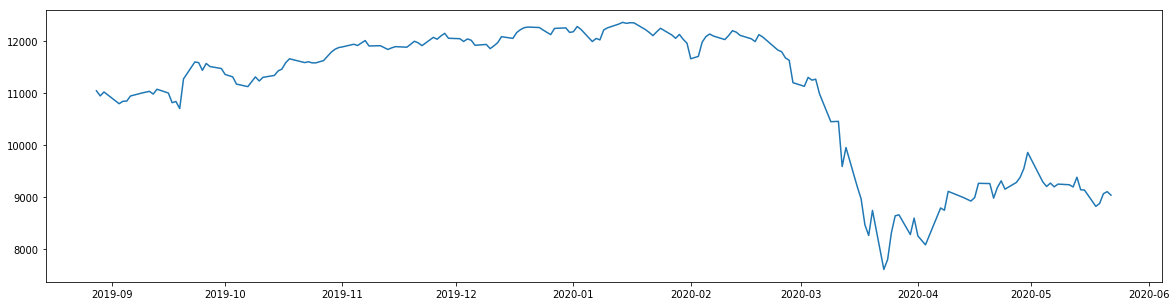

In [206]:
#Plot the data
plt.figure(figsize=(20,5))
plt.plot(df_small["Close"])

In [207]:
n_input = 40
#Split into training data
train=df_small[:-n_input]
print(df_small.shape,"===>",train.shape)

(180, 1) ===> (140, 1)


In [208]:
#Scale the data
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
#train=train.values.reshape(-1,1)#this is to be done if not scaling

In [209]:
n_features = 1
generator = TimeseriesGenerator(train, train, length=n_input, batch_size=6)

In [210]:
#Create the model
model = Sequential()
model.add(LSTM(290, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.12))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#Fit the model
model.fit_generator(generator,epochs=90)

Epoch 1/90
17/17 [==============================] - 4s 209ms/step - loss: 0.2875
Epoch 2/90
17/17 [==============================] - 1s 78ms/step - loss: 0.1599
Epoch 3/90
17/17 [==============================] - 1s 77ms/step - loss: 0.0361
Epoch 4/90
17/17 [==============================] - 1s 71ms/step - loss: 0.0264
Epoch 5/90
17/17 [==============================] - 1s 64ms/step - loss: 0.0201
Epoch 6/90
17/17 [==============================] - 1s 71ms/step - loss: 0.0247
Epoch 7/90
17/17 [==============================] - 1s 65ms/step - loss: 0.0174
Epoch 8/90
17/17 [==============================] - 1s 63ms/step - loss: 0.0215
Epoch 9/90
17/17 [==============================] - 1s 65ms/step - loss: 0.0138
Epoch 10/90
17/17 [==============================] - 1s 65ms/step - loss: 0.0234
Epoch 11/90
17/17 [==============================] - 1s 66ms/step - loss: 0.0170
Epoch 12/90
17/17 [==============================] - 1s 64ms/step - loss: 0.0147
Epoch 13/90
17/17 [=================

In [214]:
#make prediction
pred_list = []

#Recursive future prediction 
batch=train[-n_input:].reshape(1,n_input,1)
for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list[i]]],axis=1)
    
#Inverse the scale
pred_list=scaler.inverse_transform(pred_list)

In [215]:
df_predict = pd.DataFrame(pred_list, index=df_small[-n_input:].index, columns=['Prediction_Close'])
df_test = pd.concat([df_small,df_predict], axis=1)

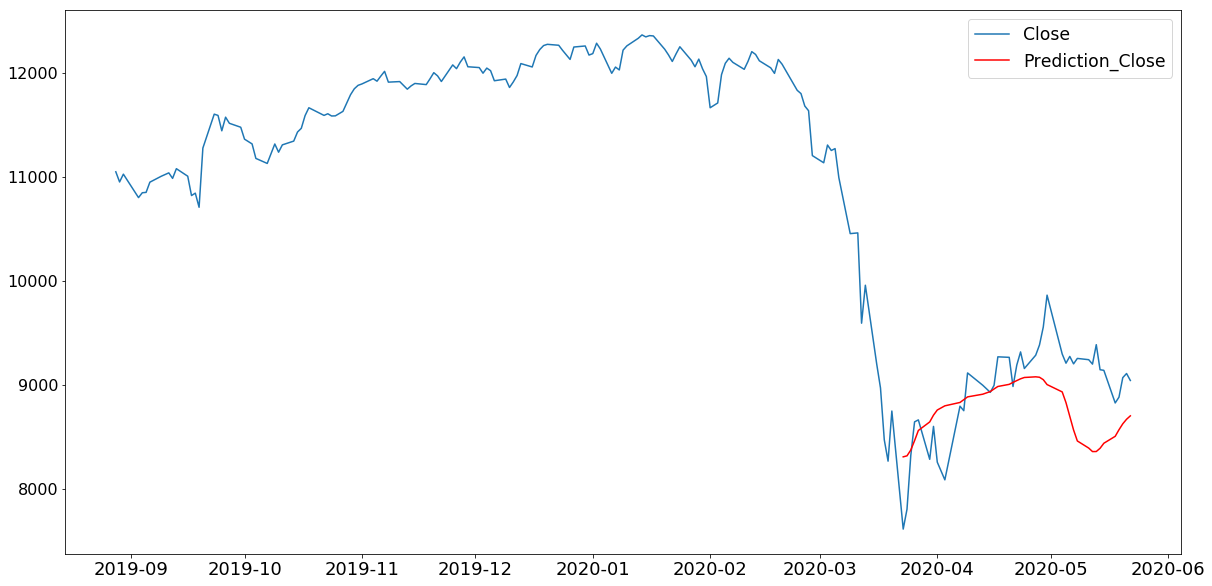

In [216]:
#plot prediction on transformed data
plt.figure(figsize=(20, 10))
plt.plot(df_test.index, df_test['Close'])
plt.plot(df_test.index, df_test['Prediction_Close'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()

In [217]:
n_input=35
layers=290
epochs=90
batch_size=6

train_predict=df_small


scaler = MinMaxScaler()
train_predict = scaler.fit_transform(train_predict)


n_features = 1
generator = TimeseriesGenerator(train_predict, train_predict, length=n_input, batch_size=batch_size)


#Create the model
model = Sequential()
model.add(LSTM(int(layers), activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.12))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
#Fit the model
model.fit_generator(generator,epochs=epochs)


#make prediction
pred_list_new = []

#Recursive future prediction 
batch=train_predict[-n_input:].reshape(1,n_input,1)
for i in range(n_input):   
    pred_list_new.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:],[[pred_list_new[i]]],axis=1)
    
#Inverse the scale
pred_list_new=scaler.inverse_transform(pred_list_new)



#Add future dates
from pandas.tseries.offsets import DateOffset
add_dates = [df_small.index[-1] + DateOffset(days=x) for x in range(0,n_input+1) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=df_small.columns)


#Create dataframes and merge them
df_predict_new = pd.DataFrame(pred_list_new, index=future_dates[-n_input:].index, columns=['Prediction'])
df_projection = pd.concat([df_small,df_predict_new], axis=1)



Epoch 1/90
25/25 [==============================] - 4s 168ms/step - loss: 0.1817
Epoch 2/90
25/25 [==============================] - 2s 62ms/step - loss: 0.0333
Epoch 3/90
25/25 [==============================] - 1s 54ms/step - loss: 0.0230
Epoch 4/90
25/25 [==============================] - 1s 54ms/step - loss: 0.0159
Epoch 5/90
25/25 [==============================] - 1s 53ms/step - loss: 0.0119
Epoch 6/90
25/25 [==============================] - 2s 84ms/step - loss: 0.0127
Epoch 7/90
25/25 [==============================] - 2s 61ms/step - loss: 0.0188
Epoch 8/90
25/25 [==============================] - 2s 62ms/step - loss: 0.0130
Epoch 9/90
25/25 [==============================] - 1s 58ms/step - loss: 0.0195
Epoch 10/90
25/25 [==============================] - 1s 57ms/step - loss: 0.0149
Epoch 11/90
25/25 [==============================] - 1s 57ms/step - loss: 0.0098
Epoch 12/90
25/25 [==============================] - 1s 55ms/step - loss: 0.0121
Epoch 13/90
25/25 [=================

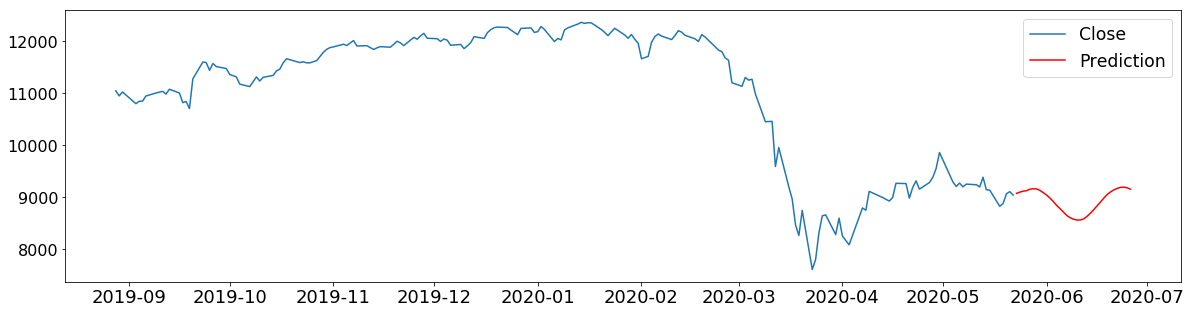

In [219]:
#Plot the projection
plt.figure(figsize=(20, 5))
plt.plot(df_projection.index, df_projection['Close'])
plt.plot(df_projection.index, df_projection['Prediction'], color='r')
plt.legend(loc='best', fontsize='xx-large')
plt.xticks(fontsize=18)
plt.yticks(fontsize=16)
plt.show()